In [214]:
#Import necessary libraries
import pandas as pd 
import numpy as np 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report



In [234]:
import collections
print(collections.__version__)

AttributeError: module 'collections' has no attribute '__version__'

In [215]:
#Load the data
data = pd.read_csv('trainingdata.csv') #Change to trainingsdata_nan.csv for the data without NAN professions

In [216]:
X = data[data.columns[1:-2]] #Define the necessary features
X.drop(columns='outofhouse', inplace=True) #Exclude outofhouse due to correlation with outhousework
y = data['test'] #Define the outcome variable
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.2, stratify = y, random_state=42) #Split the data into equal proportions of the classes

 
#transform X_train and X_test with log transformation
X_train_log = np.log1p(X_train) 
X_test_log = np.log1p(X_test)

C:\Users\20202719\AppData\Local\Temp\ipykernel_31996\3361672665.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns='outofhouse', inplace=True) #Exclude outofhouse due to correlation with outhousework


In [217]:
#Implement SMOTE (Preliminary testing)
from imblearn.over_sampling import SMOTE

smt = SMOTE()
X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train) #Normal data
X_train_smote_log, y_train_smote_log = smt.fit_resample(X_train_log, y_train) #Log transformed data

Before Counter({0.0: 1152, 1.0: 354})
After Counter({0.0: 1152, 1.0: 1152})


In [218]:
#Assign manual weights to the classes
#Define the class weights of each class (using the formula: n_samples / (n_classes * np.bincount(y)))
class_weight_0 = len(y) / (2 * np.bincount(y)[0]) 
class_weight_1 = len(y) / (2 * np.bincount(y)[1])

class_weights = {0: class_weight_0, 1: class_weight_1}


In [219]:
#Calculate the correlation matrix of all features
correlation_matrix = X_train.corr()
correlation_matrix

,numberpersons150cm,numberpersons150cmspoken,numberpersons5m,outhousework
numberpersons150cm,1.000000,0.631620,0.606499,0.334049
numberpersons150cmspoken,0.631620,1.000000,0.325870,0.313187
numberpersons5m,0.606499,0.325870,1.000000,0.256100
outhousework,0.334049,0.313187,0.256100,1.000000


### Random forest

In [230]:
#Implementation of the random forest models
from sklearn.ensemble import RandomForestClassifier

#Define the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced_subsample') #number of trees = 100
 
#Fit the classifier on the training data
clf.fit(X_train, y_train) #Adjust to the training data that needs to be used

#Predict on the test data
y_pred_clf = clf.predict(X_test) #Create the prediction using the test set

#Calculate the accuracy
accuracy_clf = accuracy_score(y_test, y_pred_clf)
print(f'Random forest Accuracy: {accuracy_clf}')

#Calculate the F1 score
f1_clf = f1_score(y_test, y_pred_clf)
print(f'Random forest F1 score: {f1_clf}')

#Calculate the precision
precision_clf = precision_score(y_test, y_pred_clf)
print(f'Random forest Precision: {precision_clf}')

#Calculate the recall
recall_clf = recall_score(y_test, y_pred_clf)
print(f'Random forest Recall: {recall_clf}')


#Perform cross-validation
cv_scores_clf = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision') #Cross validation precision
print(f'Mean cross-validation precision: {cv_scores_clf.mean()}')



Random forest Accuracy: 0.7320954907161804
Random forest F1 score: 0.1512605042016807
Random forest Precision: 0.2903225806451613
Random forest Recall: 0.10227272727272728
Mean cross-validation precision: 0.3649047619047619


Text(0.5, 1.0, 'Confusion matrix of the normal subtree-balanced random forest model')

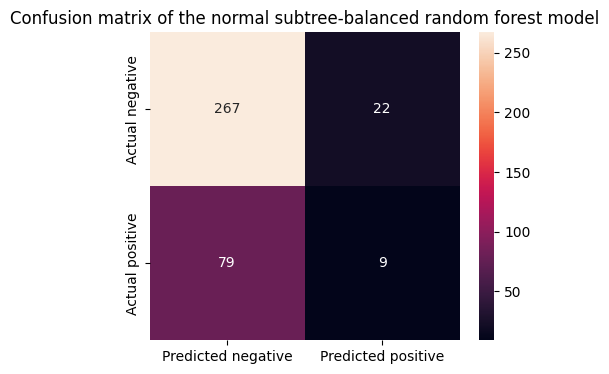

In [231]:
#plot confusion matrix of the model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_clf)
df_confmat = pd.DataFrame(conf_matrix, index = ['Actual negative', 'Actual positive'], columns = ['Predicted negative', 'Predicted positive'])
plt.figure(figsize=(5, 4))
sns.heatmap(df_confmat, annot=True, fmt="d")

plt.title('Confusion matrix of the normal subtree-balanced random forest model')

In [ ]:
#Calculate training precision
train_pred = clf.predict(X_train_smote_log)
train_precision = precision_score(y_train_smote_log, train_pred)
print(f'Training precision: {train_precision}')

Training precision: 0.9870689655172413


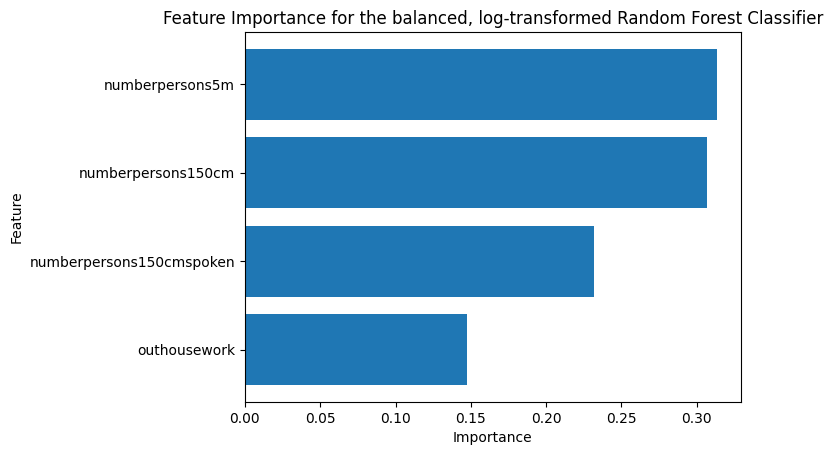

In [ ]:
#Feature evaluation
import matplotlib.pyplot as plt

#Get feature importances
importances = clf.feature_importances_

#Get feature names
feature_names = X_train.columns

#Create dataframe for visualization
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

#Sort the data by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

# Plot the sorted feature importances
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for the balanced, log-transformed Random Forest Classifier')
plt.show()



### Logistic regression

In [224]:
#Implementation of the logistic regression models
import statsmodels.api as sm


# Fit the Logistic regression model and add weights
freqweights = y_train.map(class_weights) #Map the manual class weights to the training y data
X_test_const = sm.add_constant(X_test) #Add intercept to test data
y_train.reset_index(drop=True, inplace=True) 

X_train_const = sm.add_constant(X_train)  #Add intercept to training data
X_train_const.reset_index(drop=True, inplace=True)

#Add intercept to the SMOTE data
X_train_smote_const = sm.add_constant(X_train_smote)
X_train_smote_log_const = sm.add_constant(X_train_smote_log)

#Add intercept to the log transformed data
X_train_const_log = np.log1p(X_train_const)  
X_test_const_log = np.log1p(X_test_const)

#Change according to which data needs to be used
training_data = X_train_const_log
testing_data = X_test_const_log

lr = sm.GLM(y_train, training_data, family=sm.families.Binomial(), freq_weights= freqweights) #Initialize the Logistic regression
lr_results = lr.fit()


# Calculate all metrics previously calculated for other models
testing_data.reset_index(drop=True, inplace=True)
yhat = lr_results.predict(testing_data)
prediction = list(map(round, yhat))
accuracy = accuracy_score(y_test, prediction)
print(f'lr Accuracy: {accuracy}')

f1 = f1_score(y_test, prediction)
print(f'lr F1 Score: {f1}')

precision = precision_score(y_test, prediction)
print(f'lr Precision: {precision}')

recall = recall_score(y_test, prediction)
print(f'lr Recall: {recall}')

import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
import numpy as np

class SMWrapper(BaseEstimator, RegressorMixin): #Wrapper for the statsmodels logistic regression model to calculate cross validation precision
    """A universal sklearn-style wrapper for statsmodels regressors.""" #Source: https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible
    def __init__(self, model_class, fit_intercept=True, **kwargs):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        self.model_kwargs = kwargs
        self.freq_weights = None #Define later

    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X, freq_weights=self.freq_weights, **self.model_kwargs)
        self.results_ = self.model_.fit()
        return self

    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        predictions = self.results_.predict(X)
        # Convert probabilities to binary predictions for classification
        if isinstance(self.model_, sm.GLM) and isinstance(self.model_.family, sm.families.Binomial):
            return (predictions > 0.5).astype(int)
        return predictions


# Initialize the statsmodels wrapper
model_wrapper = SMWrapper(model_class=sm.GLM, family=sm.families.Binomial())

# Use KFold for cross-validation (similar to random forest cross validation)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
precision_scores = [] #List for precision scores of each fold

for train_index, test_index in kf.split(training_data):
    # Split the data for this fold
    training_data.reset_index(drop=True, inplace=True)
    X_train_fold, X_test_fold = training_data.iloc[train_index], training_data.iloc[test_index]
    y_train_smote.reset_index(drop=True, inplace=True)
    y_train_fold, y_test_fold = y_train_smote[train_index], y_train_smote[test_index]
    freqweights.reset_index(drop=True, inplace=True)
    freq_weights_train = freqweights[train_index]  #Remove # when class weights are being used

    #train the model with frequency weights
    model_wrapper.freq_weights = freq_weights_train #Remove # when class weights are being used
    model_wrapper.fit(X_train_fold, y_train_fold)
    
    #Predict on the test set
    predictions = model_wrapper.predict(X_test_fold)
    
    #Calculate precision for this fold
    precision = precision_score(y_test_fold, predictions)
    precision_scores.append(precision)

#Calculate mean precision
mean_precision = np.mean(precision_scores)
print("Cross-validated precision:", mean_precision)
print(precision_scores)


lr Accuracy: 0.5729442970822282
lr F1 Score: 0.3924528301886792
lr Precision: 0.2937853107344633
lr Recall: 0.5909090909090909
Cross-validated precision: 0.2625541429154107
[0.20987654320987653, 0.30392156862745096, 0.34, 0.185, 0.273972602739726]


In [225]:
#Show the summary of the logistic regression model
lr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   test   No. Observations:                 1506
Model:                            GLM   Df Residuals:                  1501.73
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1033.6
Date:                Tue, 14 Jan 2025   Deviance:                       2067.2
Time:                        11:44:06   Pearson chi2:                 1.51e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01425
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.2187      0.205      1.065      0.287      -0.184       0.621
numberpersons150cm           0.3445      0.102      3.364      0.001       0.144       0.545
numberpersons150cmspoken    -0.0159      0.101     -0.157      0.875      -0.214       0.183
numberpersons5m             -0.7914      0.236     -3.360      0.001      -1.253      -0.330
outhousework                 0.4348      0.262      1.661      0.097      -0.078       0.948
============================================================================================
"""

In [213]:
#Calculate the training precision
train_pred_lr = lr_results.predict(training_data)
train_pred_lr = list(map(round, train_pred_lr))
train_precision_lr = precision_score(y_train_smote, train_pred_lr)
print(f'Training precision: {train_precision_lr}')

Training precision: 0.5357458075904677


Text(0.5, 1.0, 'Confusion matrix of the log transformed balanced logistic regression model')

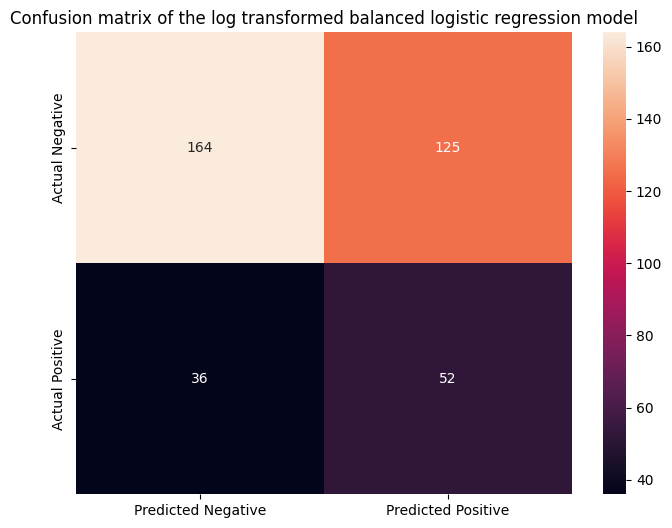

In [226]:
#Make a confusion matrix of the model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#Create a confusion matrix
conf_matrix = confusion_matrix(y_test, prediction)

#Create a dataframe for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

#Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d')
plt.title('Confusion matrix of the log transformed balanced logistic regression model')